# Test Shubert 2D
---
Description:

- Optimization (min)
- Multimodal (yes)
---
The Shubert function has several local minima and many global minima. The equation is given by:

$f\left(x, y\right) = \left(\sum_{i=1}^5 i* \cos((i+1)*x + i)\right) \left(\sum_{i=1}^5 i* \cos((i+1)*y + i)\right)$

The function is usually evaluated on the square $x, y \in [-10, 10]$, although this may be restricted
to the square $x, y \in [-5.12, 5.12]$.

Global minimum:
$f^*(x_{opt}, y_{opt}) = -186.7309$

## First we import python libraries and set up the directory

In [49]:
import os, sys
import numpy as np
from numba import njit
from scipy.stats import qmc
from collections import defaultdict
from matplotlib import pyplot as plt

# Enable LaTex in plotting.
plt.rcParams["text.usetex"] = True

PROJECT_DIR = os.path.abspath("..")
sys.path.append(PROJECT_DIR)

## Here we import all our custom PSO code

In [50]:
# Import main classes.
from pygenalgo.genome.gene import Gene
from pygenalgo.genome.chromosome import Chromosome
from pygenalgo.utils.utilities import cost_function
from pygenalgo.engines.standard_ga import StandardGA

# Import Selection Operator(s).
from pygenalgo.operators.selection.random_selector import RandomSelector
from pygenalgo.operators.selection.tournament_selector import TournamentSelector
from pygenalgo.operators.selection.linear_rank_selector import LinearRankSelector
from pygenalgo.operators.selection.neighborhood_selector import NeighborhoodSelector

# Import Crossover Operator(s).
from pygenalgo.operators.crossover.uniform_crossover import UniformCrossover

# Import Mutation Operator(s).
from pygenalgo.operators.mutation.gaussian_mutator import GaussianMutator

# Quasi-Monte-Carlo methods.
from scipy.stats import qmc

In [51]:
def count_particles_per_mode(x_pos: np.ndarray, modes: list,
                             radius: int = 0.15) -> dict:
    cppm = defaultdict(int)

    for px, py in x_pos:
        for vals in modes:
            cx, cy = vals
            if (px - cx)**2 + (py - cy)**2 <= radius**2:            
                cppm[tuple(vals)] += 1
                break
            # _end_if_
    # _end_for_
    return cppm
# _end_def_

## Define the multi-modal function

$f\left(x, y\right) = \left(\sum_{i=1}^5 i* \cos((i+1)*x + i)\right) \left(\sum_{i=1}^5 i* \cos((i+1)*y + i)\right)$

In [52]:
@njit(fastmath=True)
def fun_shubert_vectorized(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    # Define the range [1, 2, 3, 4, 5].
    i = np.arange(1, 6)

    x = np.maximum(np.minimum(x, 10.0), -10.0)
    y = np.maximum(np.minimum(y, 10.0), -10.0)

    # Calculate the first summation over each x.
    sum_x = np.sum(i[:, np.newaxis] * np.cos((i[:, np.newaxis] + 1) * x + i[:, np.newaxis]), axis=0)

    # Calculate the second summation over each y.
    sum_y = np.sum(i[:, np.newaxis] * np.cos((i[:, np.newaxis] + 1) * y + i[:, np.newaxis]), axis=0)

    # Return the product of both sums.
    return sum_x * sum_y

In [53]:
@cost_function(minimize=True)
def fun_test2D(individual: Chromosome) -> float:

    for it in individual:
        if not (-10.0 <= it.value <= +10.0):
            it.is_valid = False
    # _end_for_

    # Extract the x, y values.
    x, y = individual.values()
    
    # Compute the final value.
    f_xy = fun_shubert_vectorized(x, y)
    
    # Return the solution.
    return f_xy.item()
# _end_def_

## Here we set the GA parameters

Then we set the GA parameters, such as the genes, the number of chromosomes, etc.

In [54]:
# Random number generator.
rng = np.random.default_rng()

# Random function that enforce the boundaries in x/y.
boundary_xy = lambda: rng.uniform(-10.0, 10.0)

# Define the size of the problem (number of particles, dimensions).
n_pop, n_dim = 450, 2

# Set the bounds.
l_bounds = [-10.0, -10.0]
u_bounds = [+10.0, +10.0]

# Define the sampling method.
sample_method = "QMC"

if sample_method == "RANDOM":
    # Draw random samples for the initial points.
    xy_init = rng.uniform(-10.0, +10.0, size=(n_pop, n_dim))
else:
    # Draw samples using Latin Hyper Cube approach.
    sampler = qmc.LatinHypercube(n_dim, rng=rng, optimization="random-cd")

    # Sample initial positions.
    xy_init = sampler.random(n_pop)
    
    # Scale the positions.
    xy_init = qmc.scale(xy_init, l_bounds, u_bounds)
# _end_if_

# Initial population.
population = [Chromosome([Gene(xy_init[i, 0], boundary_xy),
                          Gene(xy_init[i, 1], boundary_xy)], np.nan, True)
              for i in range(n_pop)]

# Create the StandardGA object that will carry on the optimization.
test_GA = StandardGA(initial_pop=population,
                     fit_func=fun_test2D,
                     select_op=NeighborhoodSelector(),
                     mutate_op=GaussianMutator(),
                     crossx_op=UniformCrossover())

## Optimization process

In [55]:
test_GA(epochs=800, elitism=True, f_tol=1.0e-9, shuffle=False, correction=True, verbose=False)

Initial Avg. Fitness = 1.5344
Final   Avg. Fitness = 41.0291
Elapsed time: 21.709 seconds.


In [56]:
# Extract the data values as 'x' and 'y', for parsimony.
x_opt, y_opt = test_GA.best_chromosome().values()

# Compute the final objective functions.
f_opt = fun_shubert_vectorized(x_opt, y_opt)

# Print the resutls.
print(f"x={x_opt:.5f}, y={y_opt:.5f}", end='\n\n')
print(f"f_opt(x, y) = {f_opt.item():.5f}")

x=-1.42503, y=-0.80023

f_opt(x, y) = -186.73087


In [57]:
best_n = []

for p in test_GA.best_n(n=n_pop):
    best_n.append(p.values())

best_n = np.array(best_n)

In [58]:
# Prepare a list with all the global optima.
global_optima =[(-7.0835, -7.7083),
                (-7.0835, -1.4250),
                (-7.0835, +4.8601),
                
                (-0.8003, -7.7083),
                (-0.8003, -1.4250),
                (-0.8003, +4.8601),
                
                (+5.4858, -7.7083),
                (+5.4858, -1.4250),
                (+5.4858, +4.8601),
                
                (-7.7083, -7.0835),
                (-7.7083, -0.8003),
                (-7.7083, +5.4858),
                
                (-1.4250, -7.0835),
                (-1.4250, -0.8003),
                (-1.4250, +5.4858),
                
                (+4.8601, -7.0835),
                (+4.8601, -0.8003),
                (+4.8601, +5.4858)]

optima = np.array(global_optima)

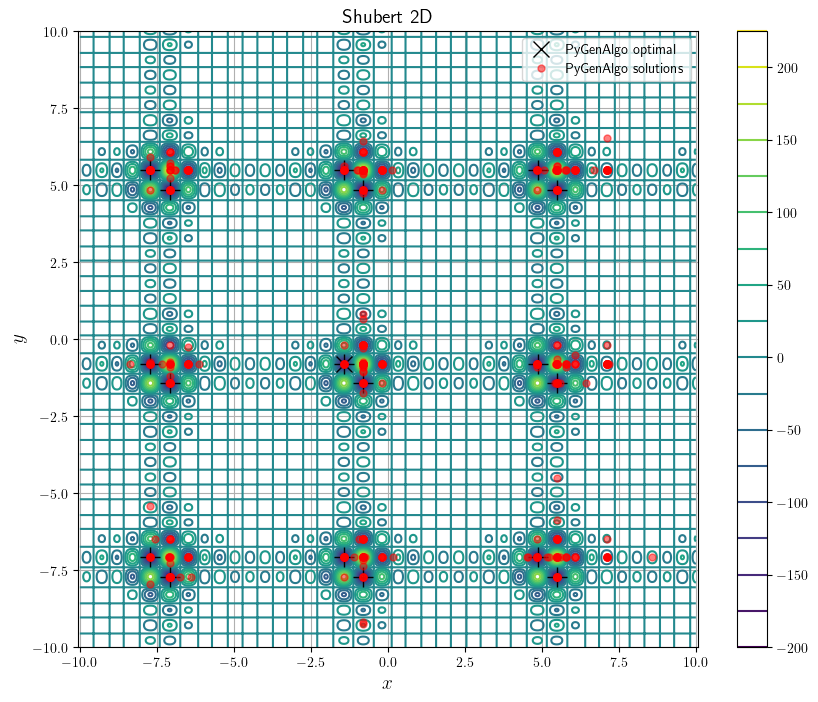

In [59]:
# Prepare the plot of the real density.
x, y = np.mgrid[-10.0:10.01:0.01, -10.0:10.01:0.01]

plt.subplots(figsize=(10, 8))

# First plot the contour of the "true" function.
plt.contour(x, y, np.reshape(fun_shubert_vectorized(x.flatten(),
                                                    y.flatten()),
                             shape=(x.shape[0], y.shape[0])),
            levels=15)

# Plot the global optima.
plt.plot(optima[:, 0], optima[:, 1], "k+", markersize=14)

# Plot the optimal PSO.
plt.plot(x_opt, y_opt, "kx", markersize=12, label="PyGenAlgo optimal")

# Plot the best_n.
plt.plot(best_n[:, 0], best_n[:, 1], "ro", alpha=0.5, markersize=5, label="PyGenAlgo solutions")

# Add labels.
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
plt.title("Shubert 2D", fontsize=14)
plt.legend()

# Final setup.
plt.colorbar()
plt.axis("equal")
plt.grid()

# Save to file.
plt.savefig("Shubert_2D.pdf", format="pdf", dpi=300)

In [60]:
counts = count_particles_per_mode(best_n, global_optima, radius=0.15)

for i, vals in enumerate(counts.items(), start=1):
    optimum, n_particles = vals
    print(f"{i:>3}, optimum: ({optimum[0]:>+7.4f}, {optimum[1]:>+7.4f}), n-particles: {n_particles:>3}")

  1, optimum: (-1.4250, -0.8003), n-particles:   6
  2, optimum: (-7.7083, -0.8003), n-particles:   7
  3, optimum: (+4.8601, -0.8003), n-particles:   9
  4, optimum: (-0.8003, -7.7083), n-particles:   4
  5, optimum: (-1.4250, +5.4858), n-particles:   9
  6, optimum: (-7.7083, +5.4858), n-particles:  15
  7, optimum: (+4.8601, +5.4858), n-particles:   5
  8, optimum: (+5.4858, -7.7083), n-particles:   9
  9, optimum: (-7.0835, -7.7083), n-particles:  13
 10, optimum: (-1.4250, -7.0835), n-particles:   9
 11, optimum: (-7.7083, -7.0835), n-particles:   5
 12, optimum: (+4.8601, -7.0835), n-particles:   7
 13, optimum: (-0.8003, +4.8601), n-particles:   7
 14, optimum: (+5.4858, +4.8601), n-particles:   8
 15, optimum: (-7.0835, +4.8601), n-particles:   8
 16, optimum: (-0.8003, -1.4250), n-particles:   7
 17, optimum: (+5.4858, -1.4250), n-particles:   9
 18, optimum: (-7.0835, -1.4250), n-particles:   8


### End of file